In [17]:
import os
import cv2
import numpy as np
import glob
import keras
#from sklearn.utils import shuffle
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split


In [2]:
path="/home/inthu/Music/flower_photos"

In [3]:
img_dir=(path+"/images")
label_dir=(path+"/labels")

img=sorted(glob.glob(img_dir+"/*.jpg"))
label= sorted(glob.glob(label_dir+"/*.jpg"))

In [4]:
print(len(img))
print(len(label))

3670
3670


In [14]:
images=[]
labels=[]
for i in range(300):
    i=cv2.imread(img[i])
    images.append(i)

for i in range(300):
    l=cv2.imread(label[i])
    labels.append(l)
    
    
images=np.array(images)
labels=np.array(labels)
print(images.shape)
print(labels.shape)

(300, 224, 224, 3)
(300, 224, 224, 3)


In [15]:
images = images.astype('float32') / 255.
labels = labels.astype('float32') / 255.

In [18]:
x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=10)
x_test, x_val, y_test, y_val = train_test_split(x_val, y_val, test_size=0.5, random_state=10)

In [19]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_val.shape)
print(y_val.shape)

(240, 224, 224, 3)
(240, 224, 224, 3)
(30, 224, 224, 3)
(30, 224, 224, 3)
(30, 224, 224, 3)
(30, 224, 224, 3)


In [26]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(224, 224, 3))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy',metrics=['accuracy'])

In [27]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 112, 112, 8)       1160      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 56, 56, 8)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 56, 56, 8)         584       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 28, 28, 8)         0         
__________

In [28]:
autoencoder.fit(x_train, y_train,
                epochs=50,
                batch_size=32,
                shuffle=True,
                validation_data=(x_val, y_val))

Train on 240 samples, validate on 30 samples
Epoch 1/50
240/240 [==============================] - 22s 93ms/step - loss: 0.6924 - acc: 0.0138 - val_loss: 0.6911 - val_acc: 0.0549
Epoch 2/50
240/240 [==============================] - 23s 95ms/step - loss: 0.6886 - acc: 0.0153 - val_loss: 0.6828 - val_acc: 0.0586
Epoch 3/50
240/240 [==============================] - 24s 98ms/step - loss: 0.6762 - acc: 0.0162 - val_loss: 0.6860 - val_acc: 0.0561
Epoch 4/50
240/240 [==============================] - 23s 98ms/step - loss: 0.6637 - acc: 0.0166 - val_loss: 0.6732 - val_acc: 0.0633
Epoch 5/50
240/240 [==============================] - 23s 96ms/step - loss: 0.6493 - acc: 0.0167 - val_loss: 0.6711 - val_acc: 0.0604
Epoch 6/50
240/240 [==============================] - 25s 103ms/step - loss: 0.6475 - acc: 0.0161 - val_loss: 0.6105 - val_acc: 0.0636
Epoch 7/50
240/240 [==============================] - 25s 104ms/step - loss: 0.6464 - acc: 0.0166 - val_loss: 0.6093 - val_acc: 0.0635
Epoch 8/50
240/

/home/inthu/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


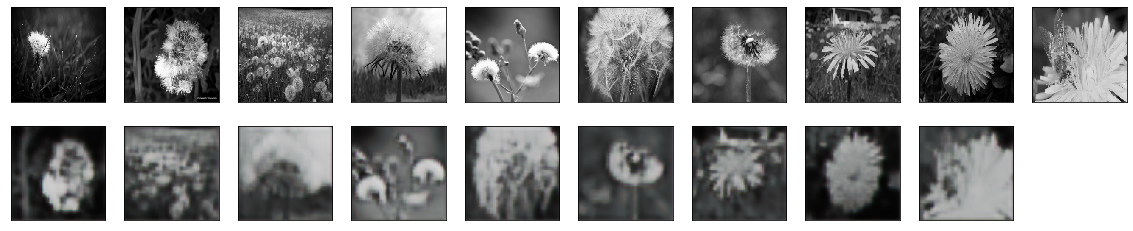

In [33]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(y_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()